In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print("Cuda is not available.Training on CPU..")
else:
    print("Cuda is available.Training on GPU")

Cuda is not available.Training on CPU..


# Loading Data

In [3]:
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(10),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
transform_validation = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_data = datasets.CIFAR10('data', train = True, download = True, transform = transform_train)
test_data = datasets.CIFAR10('data',train = False,download = True, transform = transform_validation)
batch_size = 20
num_worker = 0
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split =  int(np.floor(0.2 * num_train))
train_idx,val_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

trainloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler, num_workers = num_worker )
valloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = val_sampler, num_workers = num_worker )
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,num_workers = num_worker)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


# Visualizing the data

In [4]:
def imshow(image):
    image = image/2 + 0.5 #un-normalizing
    plt.imshow(np.transpose(image,(1,2,0)))

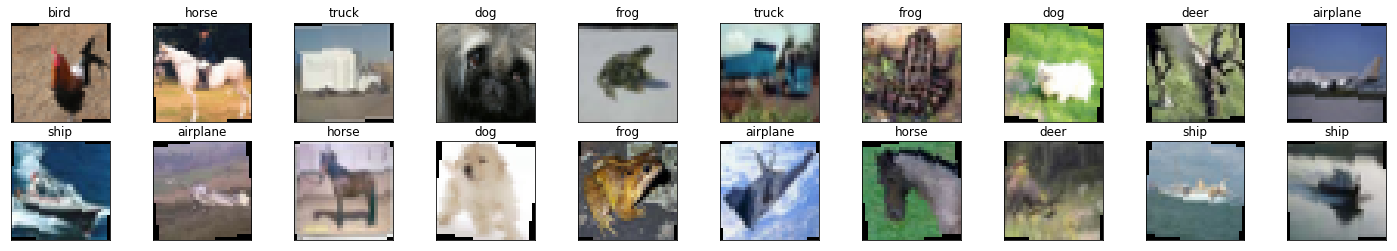

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize = (25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,20/2,idx+1,xticks =[],yticks =[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

1.0
1.0
1.0


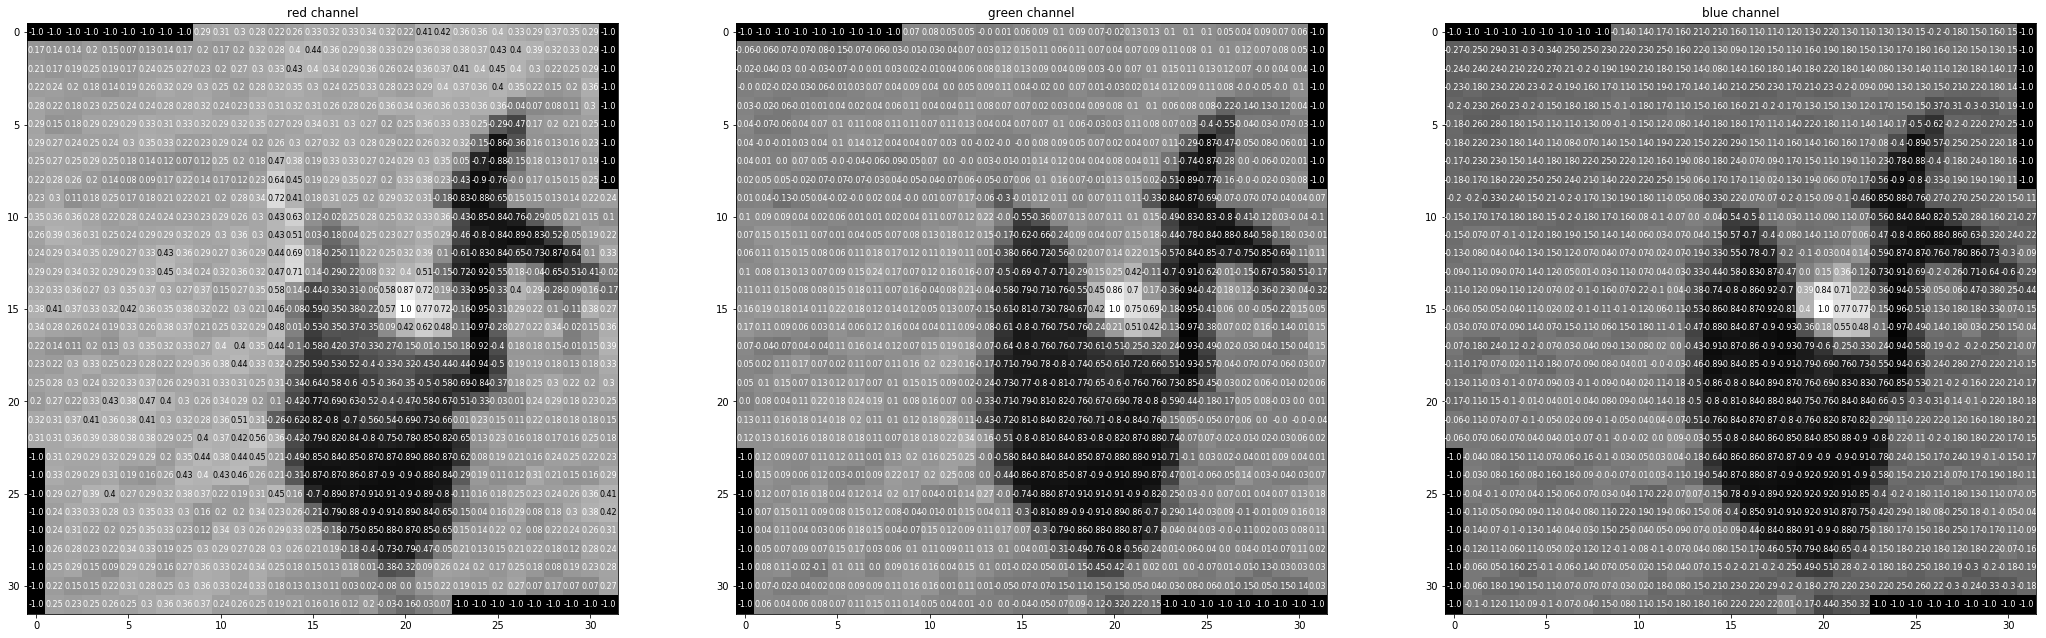

In [6]:
rgb_img = np.squeeze(images[0])
channel = ['red channel', 'green channel', 'blue channel']
fig = plt.figure(figsize =(36,36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1,3,idx+1)
    img = rgb_img[idx]
    ax.imshow(img,cmap ='gray')
    ax.set_title(channel[idx])
    width,height = img.shape
    print(img.max())
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] != 0 else 0
            ax.annotate(str(val),xy =(y,x),horizontalalignment ='center',verticalalignment ='center',size = 8,color = 'white' if img[x][y]<thresh else 'black')

# Training on dataset

In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        
        self.conv1 = nn.Conv2d(3,16,3,padding = 1)
        self.conv2 = nn.Conv2d(16,32,3,padding = 1)
        self.conv3 = nn.Conv2d(32,64,3,padding = 1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(64*4*4,500)
        self.fc2 = nn.Linear(500,10)
        
        self.drop = nn.Dropout(.2)
    
    def forward(self,x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1,64*4*4)
        x = self.drop(x)
        x = self.drop(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
network = Network()
print(network)
        
if train_on_gpu:
    network.cuda()

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (drop): Dropout(p=0.2)
)


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(),lr= 0.01)

In [9]:
epochs = 30
val_loss_min = np.Inf
for e in range(epochs):
    training_loss = 0.0
    valid_loss = 0.0
    network.train()
    for images,labels in trainloader:
        
        if train_on_gpu:
            images,labels = images.cuda(),labels.cuda()
        
        optimizer.zero_grad()
        output = network.forward(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()*images.size(0)
    
    network.eval()
    for images,labels in valloader:
        
        if train_on_gpu:
            images,labels = images.cuda(),labels.cuda()
        
        output = network.forward(images)
        loss = criterion(output,labels)
        valid_loss += loss.item()*images.size(0)
        
    training_loss = training_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(valloader.sampler)
    
    print('Epoch : {} \tTraining Loss : {: .4f} \tValidation Loss : {: .4f}'.format(e+1,training_loss,valid_loss))
    
    if valid_loss <= val_loss_min:
        print('Validation Loss decreased ({: .4f} ---> {: .4f}. Saving Model)'.format(val_loss_min,valid_loss))
        torch.save(network.state_dict(),'model_detail.pt')
        val_loss_min = valid_loss

Epoch : 1 	Training Loss :  2.0610 	Validation Loss :  1.7069
Validation Loss decreased ( inf --->  1.7069. Saving Model)
Epoch : 2 	Training Loss :  1.6021 	Validation Loss :  1.4607
Validation Loss decreased ( 1.7069 --->  1.4607. Saving Model)
Epoch : 3 	Training Loss :  1.4436 	Validation Loss :  1.3321
Validation Loss decreased ( 1.4607 --->  1.3321. Saving Model)
Epoch : 4 	Training Loss :  1.3386 	Validation Loss :  1.2446
Validation Loss decreased ( 1.3321 --->  1.2446. Saving Model)
Epoch : 5 	Training Loss :  1.2577 	Validation Loss :  1.1688
Validation Loss decreased ( 1.2446 --->  1.1688. Saving Model)
Epoch : 6 	Training Loss :  1.1894 	Validation Loss :  1.1277
Validation Loss decreased ( 1.1688 --->  1.1277. Saving Model)
Epoch : 7 	Training Loss :  1.1291 	Validation Loss :  1.0534
Validation Loss decreased ( 1.1277 --->  1.0534. Saving Model)
Epoch : 8 	Training Loss :  1.0786 	Validation Loss :  1.0036
Validation Loss decreased ( 1.0534 --->  1.0036. Saving Model)
Epo

# Testing dataset

In [17]:
network.load_state_dict(torch.load('model_detail.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [14]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
network.eval()
for images,labels in testloader:
    
    if train_on_gpu:
        images,labels = images.cuda(),labels.cuda()
    output = network.forward(images)
    loss = criterion(output,labels)
    test_loss += loss.item()*images.size(0)
    _,pred = torch.max(output, 1)
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(batch_size):
        target = labels.data[i]
        class_correct[target] += correct[i].item()
        class_total[target] += 1
        
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.4f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.7140

Test Accuracy of airplane: 83% (834/1000)
Test Accuracy of automobile: 89% (897/1000)
Test Accuracy of  bird: 64% (645/1000)
Test Accuracy of   cat: 63% (630/1000)
Test Accuracy of  deer: 71% (713/1000)
Test Accuracy of   dog: 58% (581/1000)
Test Accuracy of  frog: 81% (817/1000)
Test Accuracy of horse: 76% (762/1000)
Test Accuracy of  ship: 87% (874/1000)
Test Accuracy of truck: 81% (810/1000)

Test Accuracy (Overall): 75% (7563/10000)


# Visualising Sample Test Results

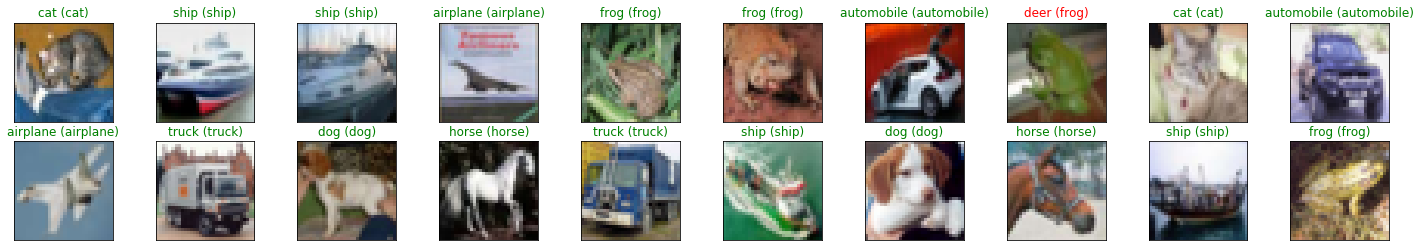

In [15]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = network.forward(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))